In [1]:
import intake
import requests
import aiohttp
import s3fs
import geopandas as gpd
from shapely.geometry import mapping
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES

# Map changes in precipitation extremes from LOCA downscaled projections
## Jan 2025

In [2]:
# set parameters
data_preload = 0  # saves data to local zarr store to make access faster
calc_prctile = 0  # only calculate percentiles if they haven't been saved to zarr already
calc_pmax = 0

data_savepath = '/glade/derecho/scratch/samantha/CAFifthAssessment/zarr_data/'

# shapefile for CA counties
shapefile_path = '/glade/u/home/samantha/codes/CAFifthAssessment/ca_counties/CA_Counties.shp'

In [3]:
# Open catalog of climate data compiled for the Fifth Assessment Report
cat = intake.open_esm_datastore(
    'https://cadcat.s3.amazonaws.com/cae-collection.json'
)

In [4]:
# List set of models
models = cat.df.source_id.unique()

# note: HadGEM3-GC31-LL only has precipitation data for SSP245 and SSP585
# Filter the list to exclude this model
models = [s for s in models if (s != 'HadGEM3-GC31-LL' and s != 'ensmean' and s != 'ERA5')]

In [5]:
models

['ACCESS-CM2',
 'CESM2-LENS',
 'CNRM-ESM2-1',
 'EC-Earth3',
 'EC-Earth3-Veg',
 'FGOALS-g3',
 'GFDL-ESM4',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MRI-ESM2-0',
 'TaiESM1',
 'CESM2']

In [6]:
# Loop over models, calculate extremes over time periods specified in author guidance
# "historical" = 1981-2010
# "mid-century" = 2041-2070
# "late-century" = 2071-2100

extr_hist = []
extr_mid = []
extr_late = []

wetday_hist = []
wetday_mid = []
wetday_late = []

for m in range(len(models)-1):
    thismod = models[m]
    print(thismod)

    # Output arrays
    histdata_thismod = []
    middata_thismod = []
    enddata_thismod = []

    wetdayhist_thismod = []
    wetdaymid_thismod = []
    wetdayend_thismod = []

    # Extract data paths for this model: historical
    cat_access_hist = cat.search(
        activity_id="LOCA2",
        source_id=thismod,
        experiment_id="historical",
        variable_id="pr",
        table_id="day"
    )
    # Extract data paths for this model: SSP3-7.0
    cat_access_ssp = cat.search(
        activity_id="LOCA2",
        source_id=thismod,
        experiment_id="ssp370",
        variable_id="pr",
        table_id ="day"
    )

    # Loop over data files, extract historical information
    for f in range(len(cat_access_hist.df['path'])):
        print(cat_access_hist.df['path'][f])

        # Preload data if specified
        savepath_hist = data_savepath + cat_access_hist.df['source_id'][f] + '_' + cat_access_hist.df['member_id'][f] + '_' + cat_access_hist.df['table_id'][f] + '_' + cat_access_hist.df['variable_id'][f] + '_hist.zarr'  

        if data_preload == 1:
            ds = xr.open_zarr(cat_access_hist.df['path'][f], storage_options={'anon': True})

            # Historical period
            hist_data = ds.sel(time=slice('1981-01-01', '2010-12-31'))
            # Store in zarr for later use
            print("Saving file: " + savepath_hist)
            hist_data.to_zarr(savepath_hist, mode='w', safe_chunks=False)

        hist_data = xr.open_zarr(savepath_hist)
        
        if calc_pmax == 1:
            # Calculate the wettest day of the year
            wdtmp = hist_data.groupby('time.year').max(dim='time')
            wetday_hist = wdtmp.mean(dim="year")

        # Append to list
        histdata_thismod.append(hist_data)
        wetdayhist_thismod.append(wetday_hist)

    # Loop over data files, extract SSP370 information
    for f in range(len(cat_access_ssp.df['path'])):
        print(cat_access_ssp.df['path'][f])

        # Preload data if specified
        savepath_mid = data_savepath + cat_access_ssp.df['source_id'][f] + '_' + cat_access_ssp.df['member_id'][f] + '_' + cat_access_ssp.df['table_id'][f] + '_' + cat_access_ssp.df['variable_id'][f] + '_mid.zarr'  
        savepath_end = data_savepath + cat_access_ssp.df['source_id'][f] + '_' + cat_access_ssp.df['member_id'][f] + '_' + cat_access_ssp.df['table_id'][f] + '_' + cat_access_ssp.df['variable_id'][f] + '_end.zarr'  

        if data_preload == 1:
            ds = xr.open_zarr(cat_access_ssp.df['path'][f], storage_options={'anon': True})

            # Mid-century
            mid_data = ds.sel(time=slice('2041-01-01', '2070-12-31'))
            # Store in zarr for later use
            print("Saving file: " + savepath_mid)
            mid_data.to_zarr(savepath_mid, mode='w', safe_chunks=False)

            # End-century
            end_data = ds.sel(time=slice('2071-01-01','2100-12-31'))
            # Store in zarr for later use
            print("Saving file: " + savepath_end)
            end_data.to_zarr(savepath_end, mode='w', safe_chunks=False)

        mid_data = xr.open_zarr(savepath_mid)
        end_data = xr.open_zarr(savepath_end)

        if calc_pmax == 1:
            wdtmp = mid_data.groupby('time.year').max(dim='time')
            wetday_mid = wdtmp.mean(dim="year")            
            wdtmp = end_data.groupby('time.year').max(dim='time')
            wetday_end = wdtmp.mean(dim="year")

        # Append to list
        middata_thismod.append(mid_data)
        enddata_thismod.append(end_data)
        wetdaymid_thismod.append(wetday_mid)
        wetdayend_thismod.append(wetday_end)

    if calc_pmax == 1:
        wetdayhist_thismod = xr.concat(wetdayhist_thismod, dim="member").mean(dim="member")
        wetdaymid_thismod = xr.concat(wetdaymid_thismod, dim="member").mean(dim="member")
        wetdayend_thismod = xr.concat(wetdayend_thismod, dim="member").mean(dim="member")

        # Save this to a separate zarr store for later use
        savepath_hist = data_savepath + cat_access_hist.df['source_id'][f] + '_wettestdayofyear_hist.zarr'  
        print("Saving file: " + savepath_hist)
        wetdayhist_thismod.to_zarr(savepath_hist, mode='w', safe_chunks=False)

        savepath_mid = data_savepath + cat_access_ssp.df['source_id'][f] + '_wettestdayofyear_mid.zarr'  
        print("Saving file: " + savepath_mid)
        wetdaymid_thismod.to_zarr(savepath_mid, mode='w', safe_chunks=False)

        savepath_end = data_savepath + cat_access_ssp.df['source_id'][f] + '_wettestdayofyear_end.zarr'  
        print("Saving file: " + savepath_end)
        wetdayend_thismod.to_zarr(savepath_end, mode='w', safe_chunks=False)

    if calc_prctile == 1:
        # Concatenate all data arrays 
        print("concatenating data")
        all_data_hist = xr.concat(histdata_thismod, dim="time")
        all_data_mid = xr.concat(middata_thismod, dim="time")
        all_data_end = xr.concat(enddata_thismod, dim="time")
        
        # Calculate the 99th percentile 
        print('percentile calculation: hist')
        combined_dataset = all_data_hist.chunk({'time': -1})
        hist_99pctile = combined_dataset.quantile(0.99, dim='time')

        print('percentile calculation: mid')
        combined_dataset = all_data_mid.chunk({'time': -1})
        mid_99pctile = combined_dataset.quantile(0.99, dim='time')

        print('percentile calculation: end')
        combined_dataset = all_data_end.chunk({'time': -1})
        end_99pctile = combined_dataset.quantile(0.99, dim='time')

        # Save this to a separate zarr store for later use
        savepath_hist = data_savepath + cat_access_hist.df['source_id'][f] + '_precip99thpctile_hist.zarr'  
        print("Saving file: " + savepath_hist)
        hist_99pctile.to_zarr(savepath_hist, mode='w', safe_chunks=False)

        savepath_mid = data_savepath + cat_access_ssp.df['source_id'][f] + '_precip99thpctile_mid.zarr'  
        print("Saving file: " + savepath_mid)
        mid_99pctile.to_zarr(savepath_mid, mode='w', safe_chunks=False)

        savepath_end = data_savepath + cat_access_ssp.df['source_id'][f] + '_precip99thpctile_end.zarr'  
        print("Saving file: " + savepath_end)
        end_99pctile.to_zarr(savepath_end, mode='w', safe_chunks=False)

GFDL-ESM4
s3://cadcat/loca2/ucsd/gfdl-esm4/historical/r1i1p1f1/day/pr/d03/
s3://cadcat/loca2/ucsd/gfdl-esm4/ssp370/r1i1p1f1/day/pr/d03/
Saving file: /glade/derecho/scratch/samantha/CAFifthAssessment/zarr_data/GFDL-ESM4_wettestdayofyear_hist.zarr
Saving file: /glade/derecho/scratch/samantha/CAFifthAssessment/zarr_data/GFDL-ESM4_wettestdayofyear_mid.zarr
Saving file: /glade/derecho/scratch/samantha/CAFifthAssessment/zarr_data/GFDL-ESM4_wettestdayofyear_end.zarr
INM-CM5-0
s3://cadcat/loca2/ucsd/inm-cm5-0/historical/r1i1p1f1/day/pr/d03/
s3://cadcat/loca2/ucsd/inm-cm5-0/historical/r2i1p1f1/day/pr/d03/
s3://cadcat/loca2/ucsd/inm-cm5-0/historical/r3i1p1f1/day/pr/d03/
s3://cadcat/loca2/ucsd/inm-cm5-0/historical/r4i1p1f1/day/pr/d03/
s3://cadcat/loca2/ucsd/inm-cm5-0/historical/r5i1p1f1/day/pr/d03/
s3://cadcat/loca2/ucsd/inm-cm5-0/ssp370/r1i1p1f1/day/pr/d03/
s3://cadcat/loca2/ucsd/inm-cm5-0/ssp370/r2i1p1f1/day/pr/d03/
s3://cadcat/loca2/ucsd/inm-cm5-0/ssp370/r3i1p1f1/day/pr/d03/
s3://cadcat/loca2/

ValueError: must supply at least one object to concatenate

In [ ]:
# Load ensemble percentile information
hist_arr = []
mid_arr = []
end_arr = []

for m in range(len(models)-1):
    thismod = models[m]
    print(thismod)
    
    # Extract data paths for this model: historical
    cat_access_hist = cat.search(
        activity_id = "LOCA2",
        source_id = thismod,
        experiment_id = "historical",
        variable_id = "pr",
        table_id = "day"
    )
    # Extract data paths for this model: SSP3-7.0
    cat_access_ssp = cat.search(
        activity_id = "LOCA2",
        source_id = thismod,
        experiment_id = "ssp370",
        variable_id = "pr",
        table_id = "day"
    )    

    # Load data
    filepath_hist = data_savepath + cat_access_hist.df['source_id'][0] + '_' + 'precip99thpctile_hist.zarr'  
    filepath_mid = data_savepath + cat_access_ssp.df['source_id'][0] + '_' + 'precip99thpctile_mid.zarr'  
    filepath_end = data_savepath + cat_access_ssp.df['source_id'][0] + '_' + 'precip99thpctile_end.zarr'  

    data_hist = xr.open_zarr(filepath_hist)
    data_mid = xr.open_zarr(filepath_mid)
    data_end = xr.open_zarr(filepath_end)

    hist_arr.append(data_hist)
    mid_arr.append(data_mid)
    end_arr.append(data_end)

In [ ]:
# Concatenate into xarray object, calculate multi-ensemble mean
hist_arr = xr.concat(hist_arr, dim="model").mean(dim="model")
mid_arr = xr.concat(mid_arr, dim="model").mean(dim="model")
end_arr = xr.concat(end_arr, dim="model").mean(dim="model")

In [10]:
# Read in shapefile for CA counties
gdf = gpd.read_file(shapefile_path)
# Reproject to match Cartopy plotting projection
gdf = gdf.to_crs(epsg=4326)

In [ ]:
# Plot results: historical 99th percentile precip
proj = ccrs.PlateCarree(central_longitude=180)
# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = proj.proj4_init
gdf_cp = gdf.to_crs(crs_proj4)

fig = plt.figure(figsize=(15, 5))
ax = plt.axes(projection=proj)
ax.set_extent([-123, -119, 33.5, 37.5], crs=ccrs.PlateCarree())
ax.gridlines()
im = plt.pcolor(hist_arr.lon, hist_arr.lat, 0.039*86400*hist_arr.pr, transform=ccrs.PlateCarree(), cmap='BrBG', vmin=-3, vmax=3)#
plt.title('Precipitation: 99th percentile (historical)')
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='k', facecolor='none')
ax.add_feature(coast_10m)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
# Plot the shapefile data (county boundaries)
gdf_cp.plot(ax=ax, facecolor='none', edgecolor='black', lw=1)
cbar = plt.colorbar(im) 
cbar.set_label('99th percentile (in/day)', rotation=270, labelpad=15)

In [ ]:
# Plot results: changes in 99th percentile precip
proj = ccrs.PlateCarree(central_longitude=180)

fig = plt.figure(figsize=(15, 5))
ax = plt.axes(projection=proj)
ax.set_extent([-123, -119, 33.5, 37.5], crs=ccrs.PlateCarree())
ax.gridlines()
im = plt.pcolor(mid_arr.lon, mid_arr.lat, 100*(mid_arr.pr - hist_arr.pr)/hist_arr.pr, transform=ccrs.PlateCarree(), cmap='BrBG')#, vmin=-50, vmax=50)#
plt.title('Extreme precip, SSP3-7.0 (mid - historical)')
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='k', facecolor='none')
ax.add_feature(coast_10m)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle='--')
gdf_cp.plot(ax=ax, facecolor='none', edgecolor='black', lw=1)
cbar = plt.colorbar(im) 
cbar.ax.set_title('Change in 99th percentile (%)')

In [ ]:
# Plot results: changes in 99th percentile precip
proj = ccrs.PlateCarree(central_longitude=180)

fig = plt.figure(figsize=(15, 5))
ax = plt.axes(projection=proj)
ax.set_extent([-123, -119, 33.5, 37.5], crs=ccrs.PlateCarree())
ax.gridlines()
im = plt.pcolor(mid_arr.lon, mid_arr.lat, 100*(end_arr.pr - hist_arr.pr)/hist_arr.pr, transform=ccrs.PlateCarree(),cmap='BrBG',vmin=-30,vmax=30)#
plt.title('Extreme precip, SSP3-7.0 (late - historical)')
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='k', facecolor='none')
ax.add_feature(coast_10m)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle='--')
gdf_cp.plot(ax=ax, facecolor='none', edgecolor='black', lw=1)
cbar = plt.colorbar(im) 
cbar.set_label('Change in 99th percentile (%)', rotation=270, labelpad=15)

In [7]:
# Load ensemble wettest day of year information
hist_arr = []
mid_arr = []
end_arr = []

for m in range(len(models)-1):
    thismod = models[m]
    print(thismod)
    
    # Extract data paths for this model: historical
    cat_access_hist = cat.search(
        activity_id = "LOCA2",
        source_id = thismod,
        experiment_id = "historical",
        variable_id = "pr",
        table_id = "day"
    )
    # Extract data paths for this model: SSP3-7.0
    cat_access_ssp = cat.search(
        activity_id = "LOCA2",
        source_id = thismod,
        experiment_id = "ssp370",
        variable_id = "pr",
        table_id = "day"
    )    

    # Load data
    filepath_hist = data_savepath + cat_access_hist.df['source_id'][0] + '_' + 'wettestdayofyear_hist.zarr'  
    filepath_mid = data_savepath + cat_access_ssp.df['source_id'][0] + '_' + 'wettestdayofyear_mid.zarr'  
    filepath_end = data_savepath + cat_access_ssp.df['source_id'][0] + '_' + 'wettestdayofyear_end.zarr'  

    data_hist = xr.open_zarr(filepath_hist)
    data_mid = xr.open_zarr(filepath_mid)
    data_end = xr.open_zarr(filepath_end)

    hist_arr.append(data_hist)
    mid_arr.append(data_mid)
    end_arr.append(data_end)

ACCESS-CM2
CESM2-LENS
CNRM-ESM2-1
EC-Earth3
EC-Earth3-Veg
FGOALS-g3
GFDL-ESM4
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
MIROC6
MPI-ESM1-2-HR
MRI-ESM2-0
TaiESM1


In [12]:
# Concatenate into xarray object, calculate multi-ensemble mean
hist_arr = xr.concat(hist_arr, dim="model").mean(dim="model")
mid_arr = xr.concat(mid_arr, dim="model").mean(dim="model")
end_arr = xr.concat(end_arr, dim="model").mean(dim="model")

/glade/derecho/scratch/samantha/tmp/ipykernel_72361/629400282.py:19: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(im)


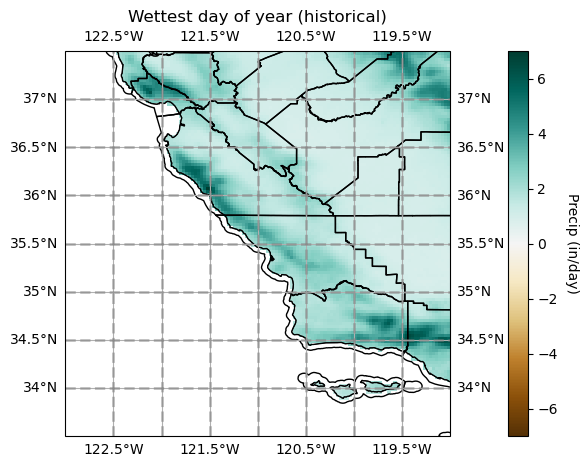

In [14]:
# Plot results: historical wettest day of the year
proj = ccrs.PlateCarree(central_longitude=180)
# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = proj.proj4_init
gdf_cp = gdf.to_crs(crs_proj4)

fig = plt.figure(figsize=(15, 5))
ax = plt.axes(projection=proj)
ax.set_extent([-123, -119, 33.5, 37.5], crs=ccrs.PlateCarree())
ax.gridlines()
im = plt.pcolor(hist_arr.lon, hist_arr.lat, 0.039*86400*hist_arr.pr, transform=ccrs.PlateCarree(), cmap='BrBG', vmin=-7, vmax=7)#
plt.title('Wettest day of year (historical)')
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='k', facecolor='none')
ax.add_feature(coast_10m)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
# Plot the shapefile data (county boundaries)
gdf_cp.plot(ax=ax, facecolor='none', edgecolor='black', lw=1)
cbar = plt.colorbar(im) 
#cbar.ax.set_title('99th percentile (in/day)')
cbar.set_label('Precip (in/day)', rotation=270, labelpad=15)

/glade/derecho/scratch/samantha/tmp/ipykernel_72361/4122854414.py:19: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(im)


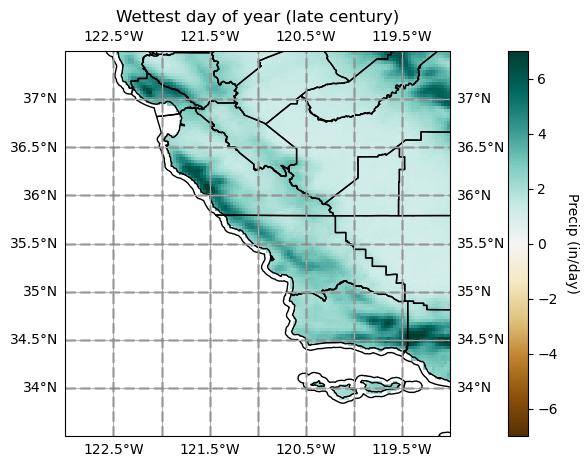

In [15]:
# Late-century wettest day of the year
proj = ccrs.PlateCarree(central_longitude=180)
# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = proj.proj4_init
gdf_cp = gdf.to_crs(crs_proj4)

fig = plt.figure(figsize=(15, 5))
ax = plt.axes(projection=proj)
ax.set_extent([-123, -119, 33.5, 37.5], crs=ccrs.PlateCarree())
ax.gridlines()
im = plt.pcolor(hist_arr.lon, hist_arr.lat, 0.039*86400*end_arr.pr, transform=ccrs.PlateCarree(), cmap='BrBG', vmin=-7, vmax=7)#
plt.title('Wettest day of year (late century)')
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='k', facecolor='none')
ax.add_feature(coast_10m)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
# Plot the shapefile data (county boundaries)
gdf_cp.plot(ax=ax, facecolor='none', edgecolor='black', lw=1)
cbar = plt.colorbar(im) 
#cbar.ax.set_title('99th percentile (in/day)')
cbar.set_label('Precip (in/day)', rotation=270, labelpad=15)

/glade/derecho/scratch/samantha/tmp/ipykernel_72361/1434209443.py:19: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar(im)


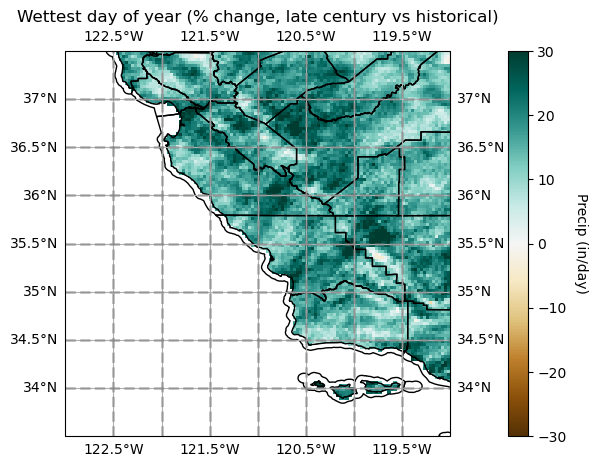

In [18]:
# Percentage change in wettest day of the year
proj = ccrs.PlateCarree(central_longitude=180)
# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = proj.proj4_init
gdf_cp = gdf.to_crs(crs_proj4)

fig = plt.figure(figsize=(15, 5))
ax = plt.axes(projection=proj)
ax.set_extent([-123, -119, 33.5, 37.5], crs=ccrs.PlateCarree())
ax.gridlines()
im = plt.pcolor(hist_arr.lon, hist_arr.lat, 100*(end_arr.pr - hist_arr.pr)/hist_arr.pr, transform=ccrs.PlateCarree(), cmap='BrBG', vmin=-30, vmax=30)#
plt.title('Wettest day of year (% change, late century vs historical)')
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='k', facecolor='none')
ax.add_feature(coast_10m)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
# Plot the shapefile data (county boundaries)
gdf_cp.plot(ax=ax, facecolor='none', edgecolor='black', lw=1)
cbar = plt.colorbar(im) 
#cbar.ax.set_title('99th percentile (in/day)')
cbar.set_label('Precip (in/day)', rotation=270, labelpad=15)